In [51]:
%matplotlib inline

%matplotlib inline
%load_ext autoreload
%autoreload 2

import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import cftime
import dask
import xarrayutils
import cartopy.crs as ccrs
from xmip.preprocessing import combined_preprocessing
from xmip.preprocessing import replace_x_y_nominal_lat_lon
from xmip.drift_removal import replace_time
from xmip.postprocessing import concat_experiments
import xmip.drift_removal as xm_dr
import xmip as xm
import xesmf as xe
import datetime
from dateutil.relativedelta import relativedelta
import utils

import scipy.signal as signal

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [52]:
#define our output grid size

ds_out = xr.Dataset(
    {
        "lat": (["lat"], np.arange(-89.5, 90.5, 1.0)),
        "lon": (["lon"], np.arange(0, 360, 1)),
        "lat_b": (["lat_b"], np.arange(-90.,91.,1.0)),
        "lon_b":(["lon_b"], np.arange(.5, 361.5, 1.0))
    }
)

In [53]:
ds_base = xr.open_mfdataset('cmip6_data/tas_Amon_GFDL-ESM4_esm-piControl_r1i1p1f1_gr1*')

In [54]:
ds_1pct = xr.open_mfdataset('cmip6_data/tas_Amon_GFDL-ESM4_1pctCO2_r1i1p1f1_gr1*')

In [55]:
ds_1pct = utils._regrid_ds(ds_1pct, ds_out)
ds_base = utils._regrid_ds(ds_base, ds_out)

/home/emfreese/anaconda3/envs/gchp/lib/python3.9/site-packages/xesmf/frontend.py:555: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  ds_out = xr.apply_ufunc(
/home/emfreese/anaconda3/envs/gchp/lib/python3.9/site-packages/xesmf/frontend.py:555: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  ds_out = xr.apply_ufunc(


In [56]:
ds_dif = ds_1pct - ds_base

In [57]:
ds_dif = ds_dif.groupby('time.year').mean()

In [58]:
G_ds = xr.open_dataset('Outputs/G_ds.nc4')['tas']
G_mean_ds = xr.open_dataset('Outputs/G_mean_ds.nc4')['tas']

In [59]:
A = utils.find_area(ds_out)

## Global Mean Analysis

In [60]:
emis_data_names = ['base','rcp85','sinks']

In [61]:
GFDL_mod= G_ds.weighted(A).mean(dim = ['lat','lon']).sel(model = 'GFDL')

In [62]:
emis_profile = {}
#GtC units
for nm in emis_data_names:
    emis_profile[nm] = pd.read_csv(f'1pct_emis_profile_{nm}.csv', header = None)
    emis_profile[nm] = np.array(emis_profile[nm][0])

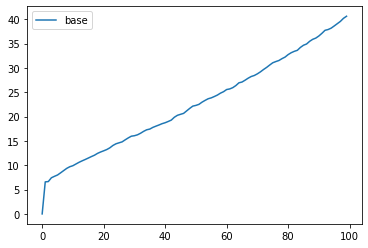

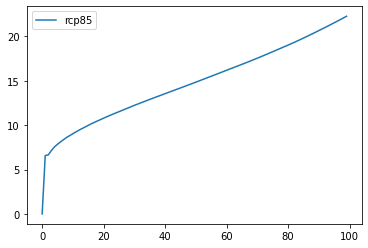

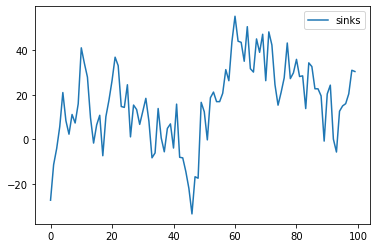

In [63]:

for nm in emis_data_names:
    fig, ax = plt.subplots()
    plt.plot(emis_profile[nm], label = nm)
    plt.legend()
    #plt.xlim(0,100)
    #plt.ylim(0,1e14)
plt.savefig('figures/1pct_increase/emis_profiles.png', bbox_inches = 'tight', dpi = 350)

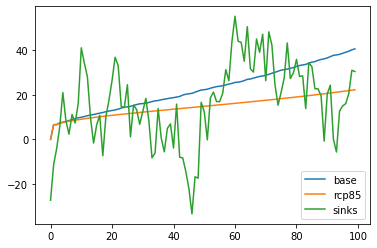

In [64]:
fig, ax = plt.subplots()
for nm in emis_data_names:
    plt.plot(emis_profile[nm], label = nm)
    plt.legend()
    # plt.xlim(0,100)
    # plt.ylim(0,10)
plt.savefig('figures/1pct_increase/emis_profiles.png', bbox_inches = 'tight', dpi = 350)

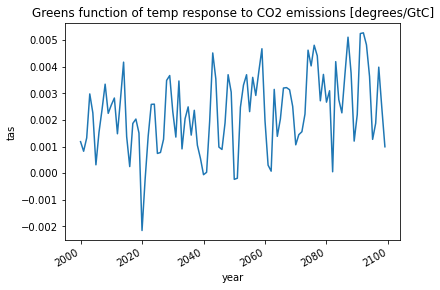

In [65]:
GFDL_mod.plot()
plt.title('Greens function of temp response to CO2 emissions [degrees/GtC]');
plt.savefig('figures/1pct_increase/single_model_GFDL_GF.png', bbox_inches = 'tight', dpi = 350)
#units of degrees/GtC

In [66]:
%%time
conv_1pct_mean = {}
for nm in emis_data_names:   
    conv_1pct_mean[nm] = signal.convolve(emis_profile[nm], np.array(GFDL_mod), 'full')

#utils.convolve_single_lev_mean(GFDL_mod, co2_arr, 1) + init_co2

CPU times: user 892 µs, sys: 0 ns, total: 892 µs
Wall time: 787 µs


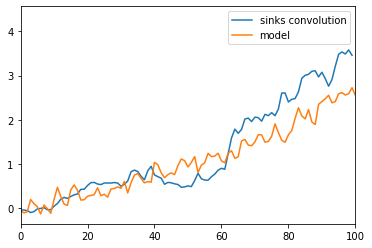

In [67]:
for nm in ['sinks']:
    plt.plot(conv_1pct_mean[nm], label = f'{nm} convolution')
plt.plot(np.arange(0,len(ds_dif['year'])), ds_dif.weighted(A).mean(dim = ['lat','lon'])['tas'], label = 'model')
plt.legend()
plt.xlim(0,100)
#plt.ylim(0,3e15)
plt.savefig('figures/1pct_increase/single_model_convolution_vs_1pct.png', bbox_inches = 'tight', dpi = 350)


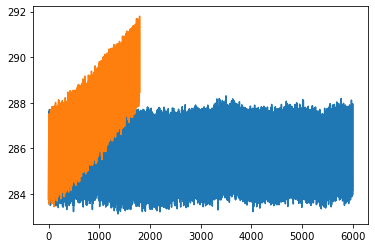

In [68]:
plt.plot(ds_base.weighted(A).mean(dim = ['lat','lon'])['tas'], label = 'base')
plt.plot(ds_1pct.weighted(A).mean(dim = ['lat','lon'])['tas'], label = '1pct')
plt.savefig('figures/1pct_increase/1pct_v_base.png', bbox_inches = 'tight', dpi = 350)

#plt.xlim(0,100)

## Spatial Analysis

In [72]:
G_ds = G_ds.rename({'year':'s'})


ValueError: cannot rename 'year' because it is not a variable or dimension in this dataset

In [79]:
ds_dif = ds_dif.rename({'year':'s'})


In [75]:
%%time
conv_1pct = {}
for nm in ['base','rcp85','sinks']:   
    conv_1pct[nm] = signal.convolve(np.array(G_ds.sel(model = 'GFDL').isel(s = slice(0,99))), emis_profile[nm][..., None, None], 'full')
    conv_1pct[nm] = utils.np_to_xr(conv_1pct[nm], G_ds.sel(model = 'GFDL'), emis_profile[nm])

CPU times: user 890 ms, sys: 431 ms, total: 1.32 s
Wall time: 1.32 s


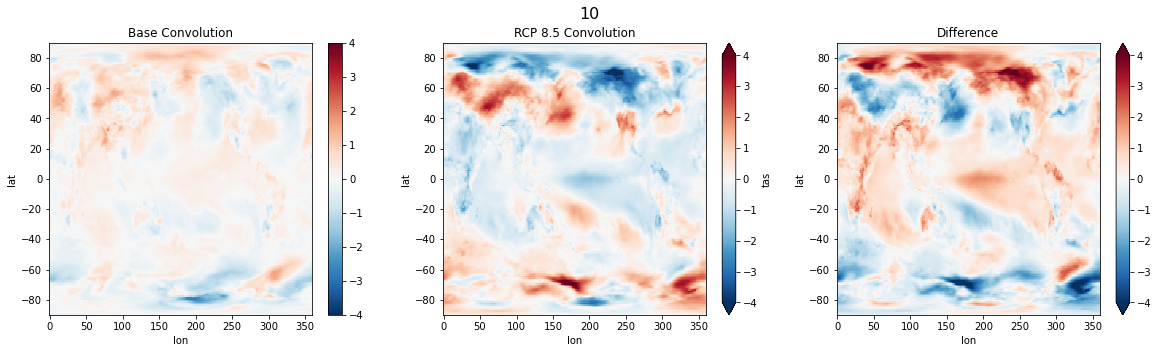

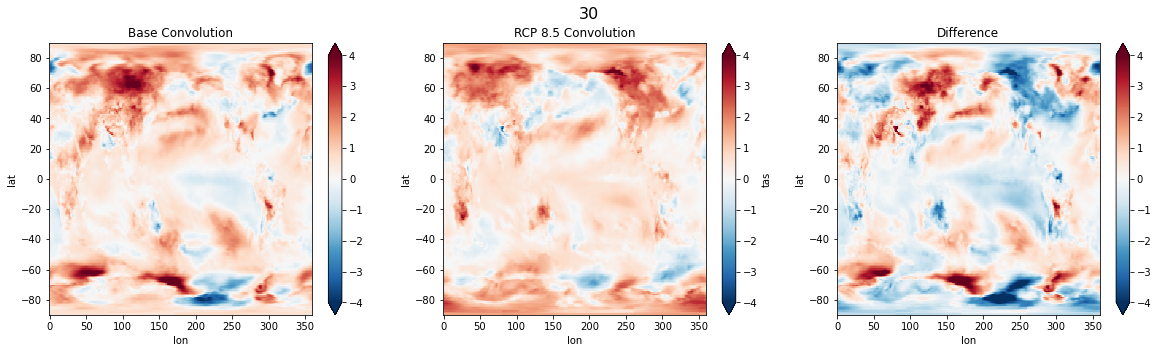

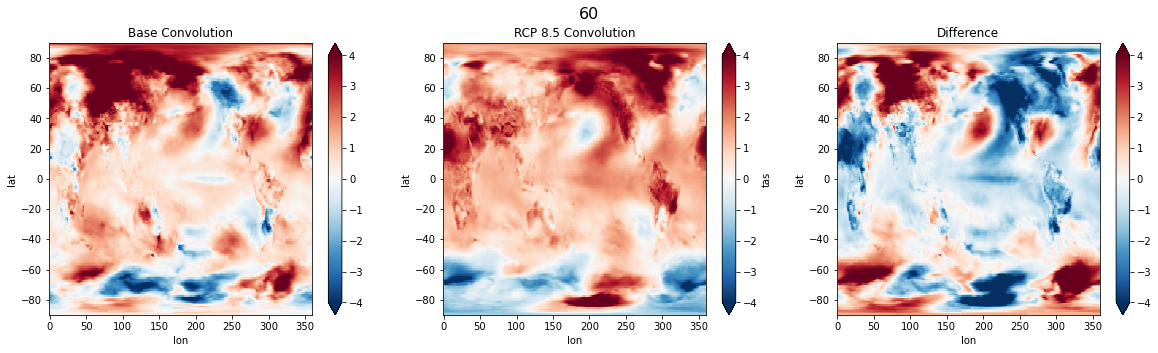

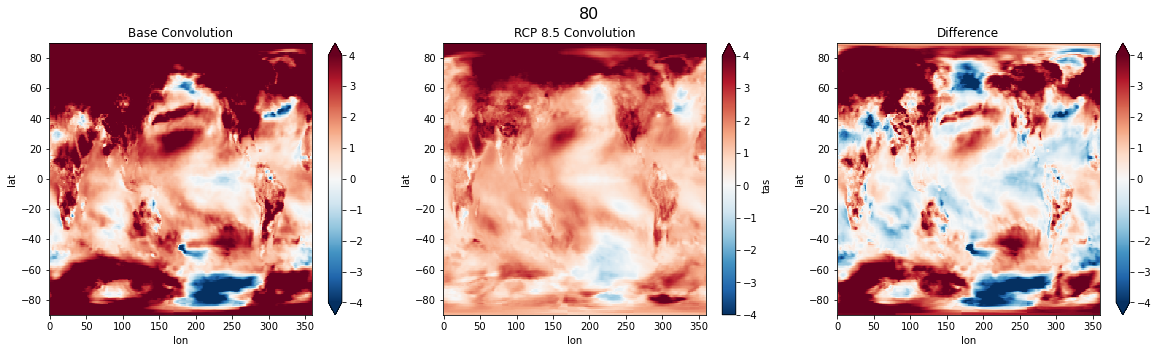

In [88]:
for t in [10, 30, 60, 80]:
    fig, [ax1, ax2, ax3] = plt.subplots(1,3, figsize = [20,5])
    
    conv_1pct['sinks'].sel(s = t).plot(ax = ax1, vmax = 4, vmin = -4, cmap = 'RdBu_r')
    ax1.set_title('Convolution')
    
    ds_dif['tas'].sel(s = t).plot(ax = ax2, vmax = 4, vmin = -4, cmap = 'RdBu_r')
    ax2.set_title('1pct data')
    
    (conv_1pct['sinks'] - ds_dif['tas']).sel(s = t).plot(ax = ax3, vmax = 4, vmin = -4, cmap = 'RdBu_r')
    ax3.set_title('Difference')
    
    plt.suptitle(t, fontsize = 16)
    plt.savefig(f'figures/1pct_increase/map_convolution_{t}.png', bbox_inches = 'tight', dpi = 350)


## Test the start date of our difference

In [116]:
ds_base2 = ds_base.isel(time = slice(12*100,6000))
ds_base2['time'] = ds_base['time'][:len(ds_base2.time)]

In [117]:
ds_base3 = ds_base.isel(time = slice(12*200,6000))
ds_base3['time'] = ds_base['time'][:len(ds_base3.time)]

In [118]:
ds_dif2 = ds_1pct - ds_base2
ds_dif3 = ds_1pct - ds_base3

In [119]:
ds_dif2 = ds_dif2.groupby('time.year').mean()
ds_dif3 = ds_dif3.groupby('time.year').mean()

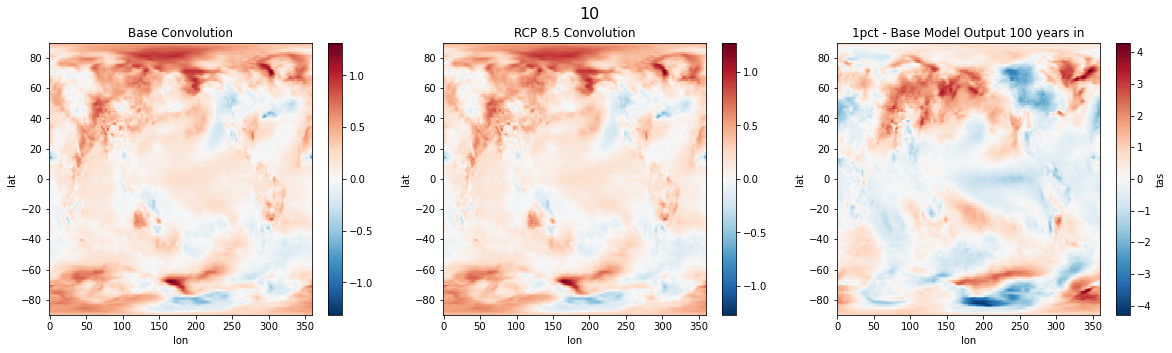

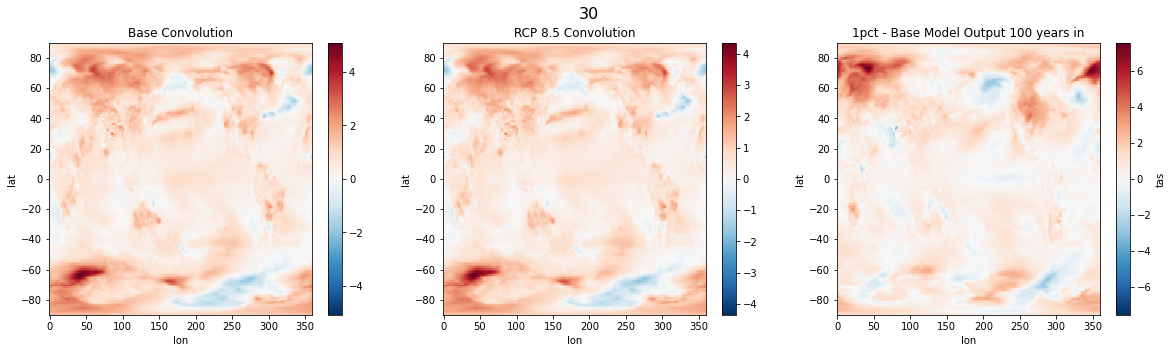

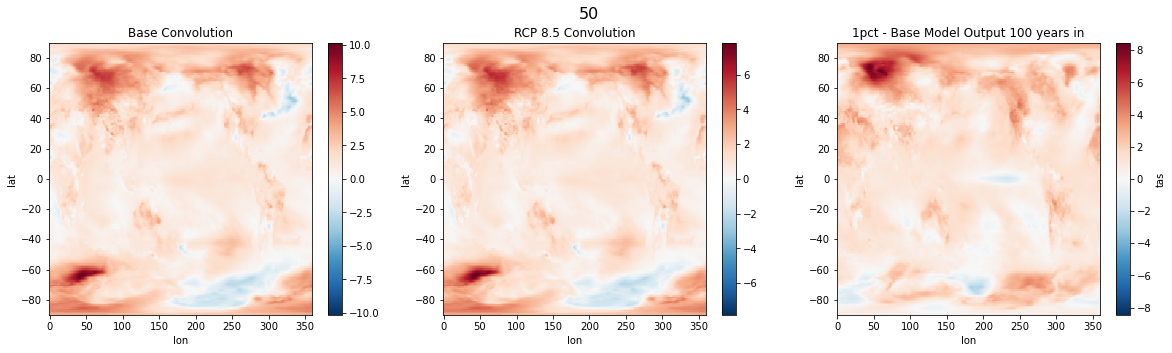

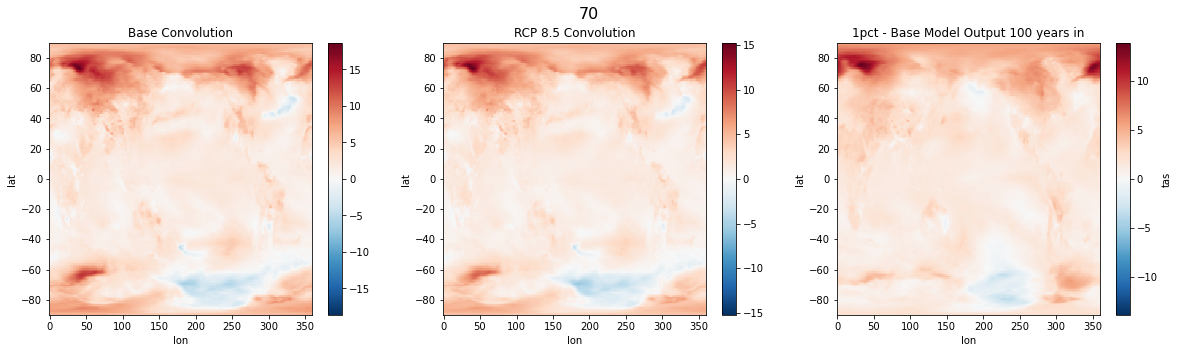

In [122]:
for t in [10,30,50,70]:
    fig, [ax1, ax2, ax3] = plt.subplots(1,3, figsize = [20,5])
    conv_1pct['base'].sel(s = t).plot(ax = ax1)
    ax1.set_title('Base Convolution')
    
    conv_1pct['rcp85'].sel(s = t).plot(ax = ax2)
    ax2.set_title('RCP 8.5 Convolution')
    
    ds_dif2['tas'].sel(year = t).plot(ax = ax3)
    ax3.set_title('1pct - Base Model Output 100 years in')
    
    plt.suptitle(f'{t}', fontsize = 16)

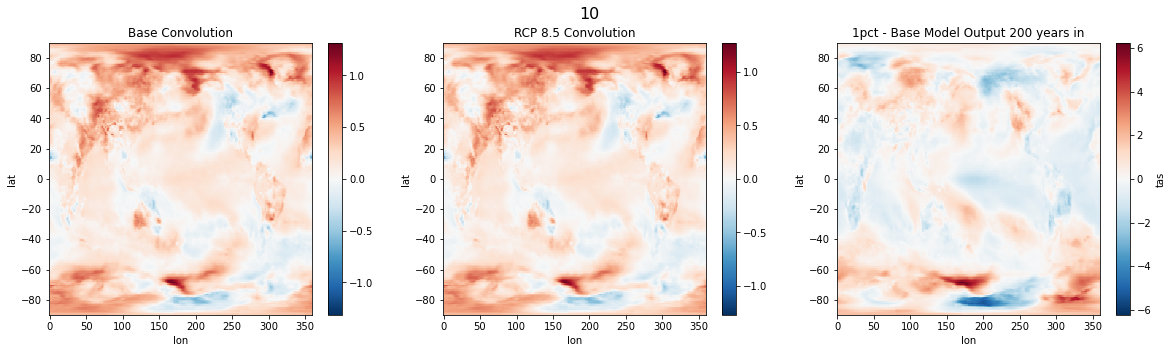

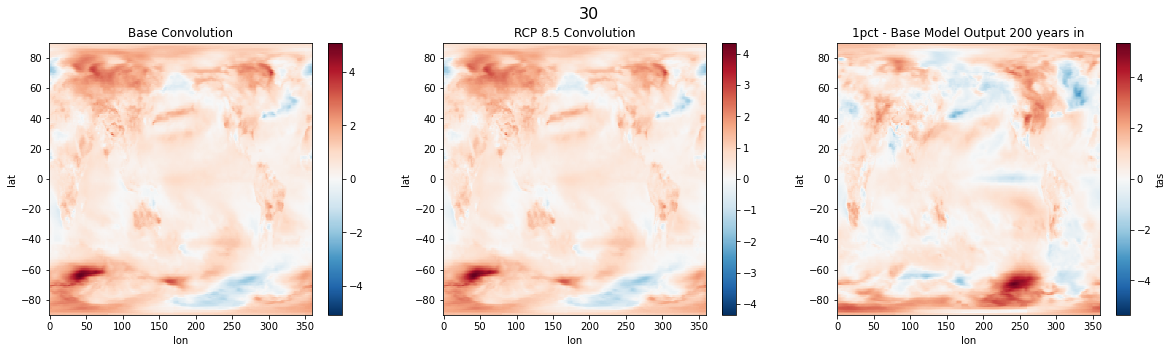

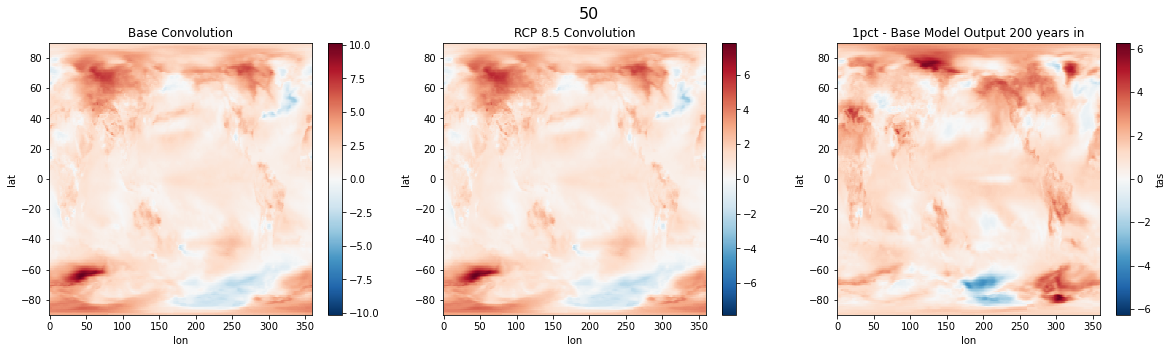

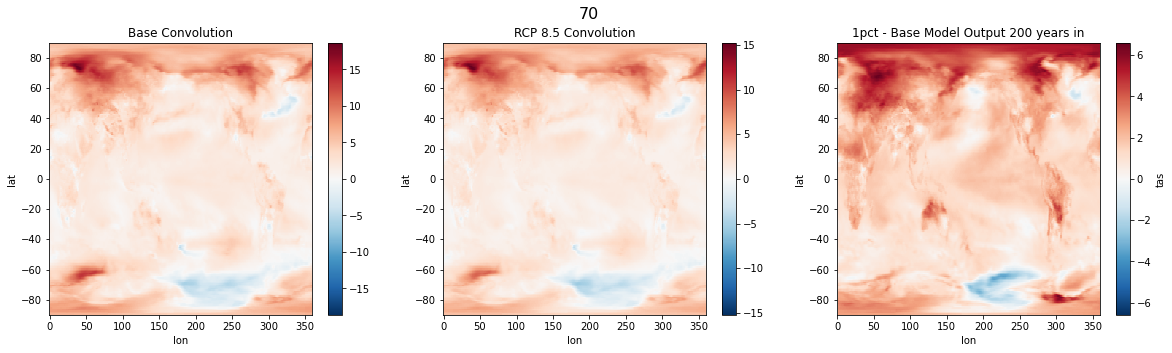

In [123]:
for t in [10,30,50,70]:
    fig, [ax1, ax2, ax3] = plt.subplots(1,3, figsize = [20,5])
    conv_1pct['base'].sel(s = t).plot(ax = ax1)
    ax1.set_title('Base Convolution')
    
    conv_1pct['rcp85'].sel(s = t).plot(ax = ax2)
    ax2.set_title('RCP 8.5 Convolution')
    
    ds_dif3['tas'].sel(year = t).plot(ax = ax3)
    ax3.set_title('1pct - Base Model Output 200 years in')
    
    plt.suptitle(f'{t}', fontsize = 16)